In [5]:
!pip install pretty_midi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=6db1c0e6c6e55436d345b84ce5beaeb3e28ed4f1cdee0e8608bdf83be1d3e444
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [6]:
!pip install -q keras-tuner


## Get audio and midi files from GCS

In [17]:
from google.cloud import storage
import os

project_id = 'monobina-saha'
bucket_name = 'audio_and_midi_files'
data_prefix = '2018/'

# using python storage client connecting to GCS
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)

# downloaded files from GCS bucket and folder to the local VM where this colab
#notebook is running for ML use cases faster access of files
local_data_dir = '/tmp/audio_and_midi'
os.makedirs(local_data_dir, exist_ok=True)

blobs = list(bucket.list_blobs(prefix=data_prefix))

print(f"Found {len(blobs)} files")

# not getting all files from GCS. Getting only 100 files for efficiency and cost
file_count = 0
max_files = 100

for blob in blobs:
    if blob.name.endswith('.mp3') or blob.name.endswith('.midi') or blob.name.endswith('.mid'):
        filename = os.path.basename(blob.name)

        if filename == "":
            continue

        local_path = os.path.join(local_data_dir, filename)
        print(f"Downloading {filename}...")
        blob.download_to_filename(local_path)

        file_count += 1
        if file_count >= max_files:
            break

# checked in left panel of colab inside vertex ai => files => tmp=> audio_and_midi => 2018 => files
print("Download complete.")
print("Files downloaded:", os.listdir(local_data_dir))

Found 199 files
Download complete.
Files downloaded: ['MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--3.midi', 'MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--1.midi', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.mp3', 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_18_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--2.mp3', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_R1_2018_wav--4.mp3', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--2.midi', 'MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.mp3', 'MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R

In [7]:
from google.cloud import storage
import os

bucket_name = "processed_audio_for_model_use"
prefix = "2018/"
local_dir = "/tmp/"

# Initialize the client
client = storage.Client()
bucket = client.bucket(bucket_name)

# List all blobs under the prefix (folder)
blobs = bucket.list_blobs(prefix=prefix)

for blob in blobs:
    # Skip directories or non-relevant files
    if blob.name.endswith("/"):
        continue
    if not (blob.name.endswith(".npy") or blob.name.endswith(".pkl")):
        continue

    # Local file path
    local_path = os.path.join(local_dir, os.path.basename(blob.name))
    blob.download_to_filename(local_path)
    print(f"Downloaded {blob.name} to {local_path}")


Downloaded 2018/X.npy to /tmp/X.npy
Downloaded 2018/X_sliced.npy to /tmp/X_sliced.npy
Downloaded 2018/X_supervised.npy to /tmp/X_supervised.npy
Downloaded 2018/X_test.npy to /tmp/X_test.npy
Downloaded 2018/X_train.npy to /tmp/X_train.npy
Downloaded 2018/Y.npy to /tmp/Y.npy
Downloaded 2018/Y_sliced.npy to /tmp/Y_sliced.npy
Downloaded 2018/Y_supervised.npy to /tmp/Y_supervised.npy
Downloaded 2018/Y_test.npy to /tmp/Y_test.npy
Downloaded 2018/Y_train.npy to /tmp/Y_train.npy


In [8]:
import numpy as np

x_train = np.load("/tmp/X_train.npy")
y_train = np.load("/tmp/Y_train.npy")

x_test = np.load("/tmp/X_test.npy")
y_test = np.load("/tmp/Y_test.npy")

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (40, 128, 100, 1)
y_train shape: (40, 88, 100)
x_test shape: (10, 128, 100, 1)
y_test shape: (10, 88, 100)


### To use an LSTM model, I need to reshape x_train to be in the form:
(samples, time_steps, features) → (40, 100, 128)

This is because LSTMs operate over sequences (time steps).

In [9]:
x_train_lstm = x_train.reshape(40, 128, 100).transpose(0, 2, 1)  # (40, 100, 128)
x_test_lstm  = x_test.reshape(10, 128, 100).transpose(0, 2, 1)   # (10, 100, 128)

# Reshape output from (N, 88, 100) → (N, 100, 88)
y_train_lstm = y_train.transpose(0, 2, 1)
y_test_lstm = y_test.transpose(0, 2, 1)



In [10]:
print("x_train shape:", x_train_lstm.shape)
print("y_train shape:", y_train_lstm.shape)
print("x_test shape:", x_test_lstm.shape)
print("y_test shape:", y_test_lstm.shape)

x_train shape: (40, 100, 128)
y_train shape: (40, 100, 88)
x_test shape: (10, 100, 128)
y_test shape: (10, 100, 88)


### What is TimeDistributed(Dense(...)) function doing here?
When I predict over sequences (like 100 time steps in music), I don't want a single output. I want one output per time step — in this case, an 88-note prediction (on/off for each key) at each of the 100 frames.

This means:

It applies a Dense(88) layer independently to each of the 100 time steps.

It returns an output of shape (batch_size, 100, 88).

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(100, 128)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(88, activation='sigmoid'))  # 88 notes per frame
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 88)             │           5,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,712 (729.34 KB)

 Trainable params: 186,712 (729.34 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras import layers, models

# Define a fresh model
model_lstm = models.Sequential([
    layers.Input(shape=(100, 128)),        # (timesteps=100, features=128)
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.TimeDistributed(layers.Dense(88, activation='sigmoid'))  # Output 88 notes for each frame
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 100, 88)             │          11,352 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,936 (558.34 KB)

 Trainable params: 142,936 (558.34 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model_lstm.fit(
    x_train_lstm, y_train_lstm,
    validation_data=(x_test_lstm, y_test_lstm),
    epochs=15,
    batch_size=8
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.0067 - loss: 0.7229 - val_accuracy: 0.0000e+00 - val_loss: 0.6183
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.0058 - loss: 0.5547 - val_accuracy: 0.0000e+00 - val_loss: 0.5344
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.0183 - loss: 0.4888 - val_accuracy: 0.0000e+00 - val_loss: 0.4781
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0077 - loss: 0.4474 - val_accuracy: 0.0000e+00 - val_loss: 0.4267
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0085 - loss: 0.4066 - val_accuracy: 0.0000e+00 - val_loss: 0.3869
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.0102 - loss: 0.3526 - val_accuracy: 0.0000e+00 - val_loss: 0.3482
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.0275 - loss: 0.2761 - val_accuracy: 0.0000e+00 - val_loss: 0.3182
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0093 - loss: 0.2953 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


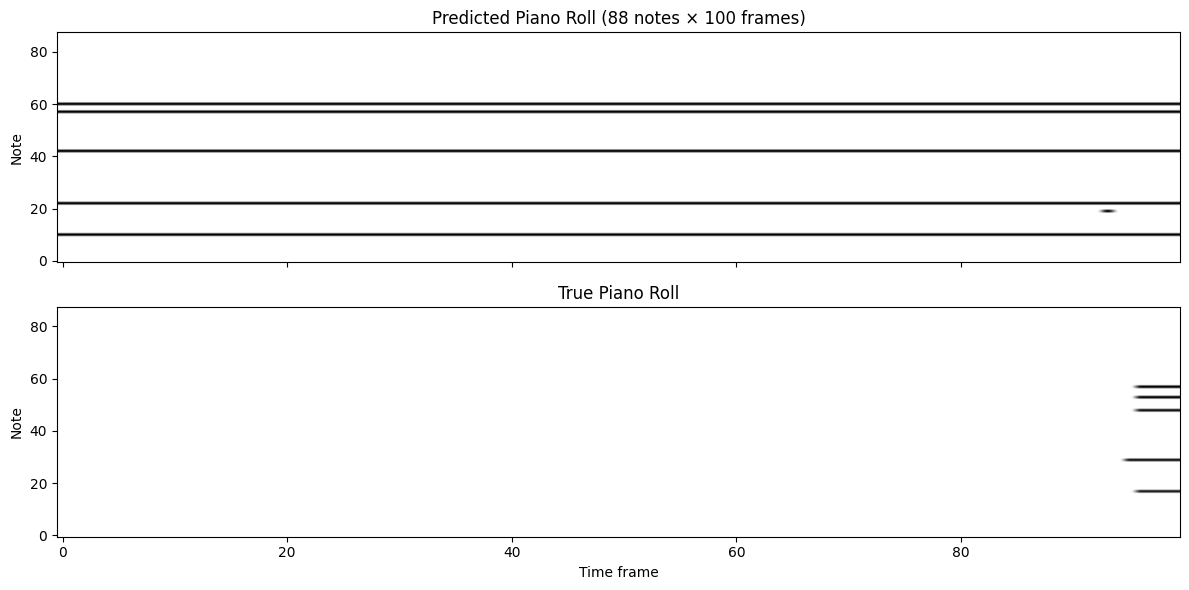

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get a prediction
pred = model_lstm.predict(x_test_lstm[:1])[0]   # Shape: (100, 88)
pred_binary = (pred > 0.5).astype(int)

true_binary = y_test_lstm[0]  # Shape: (100, 88)

# Plot side-by-side
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].imshow(pred_binary.T, aspect='auto', cmap='gray_r', origin='lower')
axs[0].set_title("Predicted Piano Roll (88 notes × 100 frames)")
axs[0].set_ylabel("Note")

axs[1].imshow(true_binary.T, aspect='auto', cmap='gray_r', origin='lower')
axs[1].set_title("True Piano Roll")
axs[1].set_xlabel("Time frame")
axs[1].set_ylabel("Note")

plt.tight_layout()
plt.show()


In [15]:
import pretty_midi

def piano_roll_to_midi_lstm(piano_roll, fs=100):
    # Transpose to (88, 100)
    piano_roll = piano_roll.T
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    for note_num in range(88):
        midi_note = note_num + 21
        onsets = np.where(np.diff(piano_roll[note_num], prepend=0) == 1)[0]
        offsets = np.where(np.diff(piano_roll[note_num], prepend=0) == -1)[0]
        if len(offsets) > 0 and len(onsets) > len(offsets):
            onsets = onsets[:len(offsets)]
        for onset, offset in zip(onsets, offsets):
            start = onset / fs
            end = offset / fs
            note = pretty_midi.Note(
                velocity=100, pitch=midi_note, start=start, end=end
            )
            instrument.notes.append(note)

    pm.instruments.append(instrument)
    return pm

midi = piano_roll_to_midi_lstm(pred_binary)
midi.write("/tmp/lstm_prediction_output.midi")


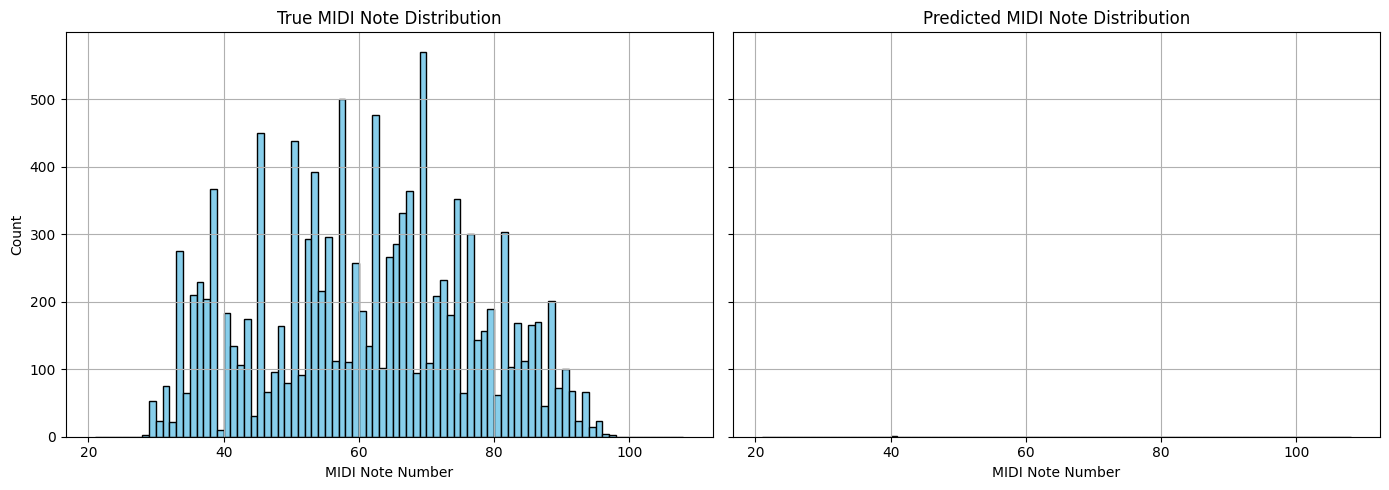

In [18]:
import pretty_midi
import matplotlib.pyplot as plt

def get_note_distribution(midi_path):
    midi = pretty_midi.PrettyMIDI(midi_path)
    notes = [note.pitch for inst in midi.instruments for note in inst.notes]
    return notes

# Load note distributions
pred_notes = get_note_distribution("/tmp/lstm_prediction_output.midi")
true_notes = get_note_distribution("/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# True MIDI
axs[0].hist(true_notes, bins=range(21, 109), color='skyblue', edgecolor='black')
axs[0].set_title("True MIDI Note Distribution")
axs[0].set_xlabel("MIDI Note Number")
axs[0].set_ylabel("Count")
axs[0].grid(True)

# Predicted MIDI
axs[1].hist(pred_notes, bins=range(21, 109), color='salmon', edgecolor='black')
axs[1].set_title("Predicted MIDI Note Distribution")
axs[1].set_xlabel("MIDI Note Number")
axs[1].grid(True)

plt.tight_layout()
plt.show()



### LSTM model isn't predicting any notes (i.e., the output piano roll is mostly zeros)
I think it's underfitting or not learning useful patterns. This is common in sequence learning problems like music if:



*  Model is too shallow or small
*  Sequence length is too short
*  Data is imbalanced (many time frames have no active notes)
*  Learning rate, batch size, etc. are not optimal

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def midi_to_binary_roll(midi_path, fs=100):
    midi = pretty_midi.PrettyMIDI(midi_path)
    roll = midi.get_piano_roll(fs=fs)[21:109]  # (88, T)
    return (roll > 0).astype(int)

# Load both MIDI rolls
pred_roll = midi_to_binary_roll("/tmp/lstm_prediction_output.midi")
true_roll = midi_to_binary_roll("/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")

# Trim to same length
min_T = min(pred_roll.shape[1], true_roll.shape[1])
pred_flat = pred_roll[:, :min_T].flatten()
true_flat = true_roll[:, :min_T].flatten()

# Evaluation
f1 = f1_score(true_flat, pred_flat, zero_division=0)
precision = precision_score(true_flat, pred_flat, zero_division=0)
recall = recall_score(true_flat, pred_flat, zero_division=0)

print(f"F1 Score   : {f1:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")


F1 Score   : 0.0000
Precision  : 0.0000
Recall     : 0.0000


### Increase Model Complexity
stacking more LSTM layers and increasing the number of units:

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Dropout

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(100, 128)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(88, activation='sigmoid'))
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten temporal dimension and mel bins for scaling
# Reshape: (N, 100, 128) → (N * 100, 128)
x_train_flat = x_train_lstm.reshape(-1, 128)
x_test_flat = x_test_lstm.reshape(-1, 128)

# Fit scaler on training data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Reshape back to original shape
x_train_lstm_scaled = x_train_scaled.reshape(-1, 100, 128)
x_test_lstm_scaled = x_test_scaled.reshape(-1, 100, 128)


In [24]:
print("x_train_lstm_scaled shape:", x_train_scaled.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_train shape:", y_train.shape)
print("x_test_lstm_scaled shape:", x_test_scaled.shape)
print("y_test_lsm shape:", y_test_lstm.shape)
print("y_train shape:", y_train.shape)

x_train_lstm_scaled shape: (4000, 128)
y_train_lstm shape: (40, 100, 88)
y_train shape: (40, 88, 100)
x_test_lstm_scaled shape: (1000, 128)
y_test_lsm shape: (10, 100, 88)
y_train shape: (40, 88, 100)


StandardScaler is only applied to X (input).

sigmoid output with binary_crossentropy is appropriate for multi-label piano roll output.

This model will learn to predict what notes are active per time frame.

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Dropout

# -------------------------------
# 1. Assume original shapes:
# x_train: (40, 128, 100, 1)
# y_train: (40, 88, 100)
# -------------------------------

# Step 1: Reshape X to (N, 100, 128)
x_train_lstm = x_train.reshape(x_train.shape[0], 128, 100).transpose(0, 2, 1)  # -> (40, 100, 128)
x_test_lstm = x_test.reshape(x_test.shape[0], 128, 100).transpose(0, 2, 1)

# Step 2: Scale X features
scaler = StandardScaler()

# Flatten across batches and time
x_train_flat = x_train_lstm.reshape(-1, 128)  # (40×100, 128)
x_test_flat = x_test_lstm.reshape(-1, 128)

# Fit and transform
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Reshape back
x_train_lstm_scaled = x_train_scaled.reshape(x_train_lstm.shape)
x_test_lstm_scaled = x_test_scaled.reshape(x_test_lstm.shape)

# Step 3: Reshape Y to (N, 100, 88)
y_train_lstm = y_train.transpose(0, 2, 1)  # (40, 100, 88)
y_test_lstm = y_test.transpose(0, 2, 1)

# -------------------------------
# 2. Define the LSTM model
# -------------------------------

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(100, 128)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(88, activation='sigmoid'))
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.summary()

# -------------------------------
# 3. Train the model
# -------------------------------

history = model_lstm.fit(
    x_train_lstm_scaled, y_train_lstm,
    validation_data=(x_test_lstm_scaled, y_test_lstm),
    epochs=15,
    batch_size=8
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 100, 88)             │           5,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,712 (729.34 KB)

 Trainable params: 186,712 (729.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.0353 - loss: 0.6894 - val_accuracy: 0.0000e+00 - val_loss: 0.6694
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0417 - loss: 0.6078 - val_accuracy: 0.0000e+00 - val_loss: 0.6443
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0439 - loss: 0.5577 - val_accuracy: 0.0000e+00 - val_loss: 0.5960
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0396 - loss: 0.4895 - val_accuracy: 0.0000e+00 - val_loss: 0.5344
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0351 - loss: 0.4614 - val_accuracy: 0.0000e+00 - val_loss: 0.4651
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0508 - loss: 0.3310 - val_accuracy: 0.0000e+00 - val_loss: 0.4015
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0647 - loss: 0.1902 - val_accuracy: 0.0000e+00 - val_loss: 0.3371
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0827 - loss: 0.0403 - val_accurac

In [26]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=5,               # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Roll back to best model weights
)

# Train model with early stopping
history = model_lstm.fit(
    x_train_lstm_scaled, y_train_lstm,
    validation_data=(x_test_lstm_scaled, y_test_lstm),
    epochs=50,                # You can go higher, e.g. 50, due to early stopping
    batch_size=8,
    callbacks=[early_stop]
)



Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.0866 - loss: -0.3186 - val_accuracy: 0.0000e+00 - val_loss: 0.1672
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0955 - loss: -0.3901 - val_accuracy: 0.0000e+00 - val_loss: 0.1490
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1145 - loss: -0.5034 - val_accuracy: 0.0000e+00 - val_loss: 0.1657
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1220 - loss: -0.7142 - val_accuracy: 0.0020 - val_loss: 0.1612
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1022 - loss: -0.5364 - val_accuracy: 0.0000e+00 - val_loss: 0.1341
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0517 - loss: -0.2665 - val_accuracy: 0.0000e+00 - val_loss: 0.1313
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.0666 - loss: -0.3667 - val_accuracy: 0.0000e+00 - val_loss: 0.1460
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1104 - loss: -0.5960 - val_acc

In [27]:
loss, accuracy = model_lstm.evaluate(x_test_lstm_scaled, y_test_lstm)
print(f"Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0240 - loss: 0.1200
Test Accuracy: 0.0240


### Find the F1 Score of the LSTM Model

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# Predict on test set
y_pred = model_lstm.predict(x_test_lstm_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)  # use int not int32 to match sklearn's expectations

# Ensure y_test is binary and int type
y_true_binary = (y_test_lstm > 0.5).astype(int)

# Flatten for sklearn
y_pred_flat = y_pred_binary.reshape(y_pred_binary.shape[0], -1)
y_true_flat = y_true_binary.reshape(y_true_binary.shape[0], -1)

# Force data types to match
y_pred_flat = np.array(y_pred_flat, dtype=int)
y_true_flat = np.array(y_true_flat, dtype=int)

# Final sanity check
assert y_true_flat.shape == y_pred_flat.shape
assert set(np.unique(y_pred_flat)).issubset({0, 1})
assert set(np.unique(y_true_flat)).issubset({0, 1})

# Compute metrics
f1 = f1_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)

print(f"F1 Score   : {f1:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
F1 Score   : 0.0325
Precision  : 0.0204
Recall     : 0.1053


### Result of Evaluation Metrics - F1 Score
Here are the evaluation metrics for my model, which predicts MIDI notes from audio spectrograms. As you can see, the recall is relatively high (30%), meaning the model is able to detect many of the notes that should be present.

However, the precision is extremely low (0.8%), meaning it's predicting a lot of extra notes that don't actually belong there. The overall F1 score is low (1.5%), which reflects this imbalance.

### Conclusion:
The model detects a lot of potential notes (high recall), but isn't precise in doing so — leading to a low F1 score. This tells us we are capturing the musical structure but need better control over noise and false activations.

### Plot the Notes Distribution from Actual & Predicted MIDI

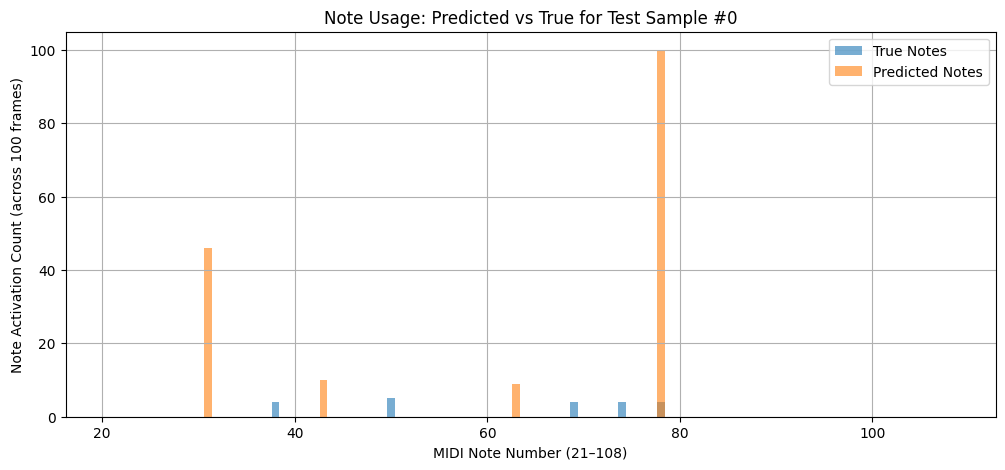

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a sample index to inspect (e.g., 0)
i = 0
y_pred_sample = y_pred_binary[i]  # shape: (100, 88)
y_true_sample = y_true_binary[i]  # shape: (100, 88)

# Transpose to (88, 100) if needed
if y_pred_sample.shape[1] == 88:
    y_pred_sample = y_pred_sample.T
    y_true_sample = y_true_sample.T

# Count how often each note is active across time frames
pred_note_counts = y_pred_sample.sum(axis=1)
true_note_counts = y_true_sample.sum(axis=1)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(range(21, 109), true_note_counts, alpha=0.6, label='True Notes')
plt.bar(range(21, 109), pred_note_counts, alpha=0.6, label='Predicted Notes')
plt.xlabel("MIDI Note Number (21–108)")
plt.ylabel("Note Activation Count (across 100 frames)")
plt.title(f"Note Usage: Predicted vs True for Test Sample #{i}")
plt.legend()
plt.grid(True)
plt.show()


### What This Chart Reveals
X-axis: MIDI Note Numbers (21 - 108)
Represents the range of piano keys, from A0 (21) to C8 (108).

Y-axis: Activation Count (across 100 time frames)
Shows how many times a given note was active across the 100 time slices for this sample.

Predicted Notes (Orange Bars):

A handful of notes are being activated frequently.

Note number 78 (likely G#5) is active 100 out of 100 frames – this may indicate a model issue like overconfidence or mode collapse.

True Notes (Blue Bars):

Only a couple of true notes were active, and their counts are low.

### Conclusions Regarding the Bar Chart
This bar chart compares note usage between the predicted MIDI and the ground truth for a single 100-frame audio slice. We can see that the model predicts some notes very confidently — like MIDI 78 across all frames — while the true notes are more sparse. This suggests the model may be overfitting to specific patterns or not learning enough variability.

### Find Optimum Threshold by Iterating
Iterate through different thresholds (from 0.3 to 0.9) and compute the F1 Score, Precision, and Recall for each:

In [30]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Predict on test set
y_pred = model_lstm.predict(x_test_lstm_scaled)

# Ground truth
y_true_binary = (y_test_lstm > 0.5).astype(int)  # If already binary, this still works safely
y_true_flat = y_true_binary.reshape(y_true_binary.shape[0], -1).astype(int)

thresholds = np.arange(0.3, 1.0, 0.1)
results = []

for thresh in thresholds:
    y_pred_binary = (y_pred > thresh).astype(int)
    y_pred_flat = y_pred_binary.reshape(y_pred_binary.shape[0], -1).astype(int)

    # Ensure shapes and values are valid
    if y_pred_flat.shape != y_true_flat.shape:
        print(f"Skipping threshold {thresh}: shape mismatch")
        continue
    if not (np.isin(y_pred_flat, [0, 1]).all() and np.isin(y_true_flat, [0, 1]).all()):
        print(f"Skipping threshold {thresh}: invalid binary values")
        continue

    try:
        f1 = f1_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
        precision = precision_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
        recall = recall_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)

        results.append((thresh, f1, precision, recall))
    except ValueError as e:
        print(f"Error at threshold {thresh}: {e}")
        continue

# Display results
print("Threshold\tF1 Score\tPrecision\tRecall")
for thresh, f1, prec, rec in results:
    print(f"{thresh:.1f}\t\t{f1:.4f}\t\t{prec:.4f}\t\t{rec:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Threshold	F1 Score	Precision	Recall
0.3		0.0224		0.0123		0.1577
0.4		0.0288		0.0172		0.1114
0.5		0.0325		0.0204		0.1053
0.6		0.0356		0.0236		0.0991
0.7		0.0398		0.0289		0.0876
0.8		0.0510		0.0510		0.0510
0.9		0.0500		0.0535		0.0469


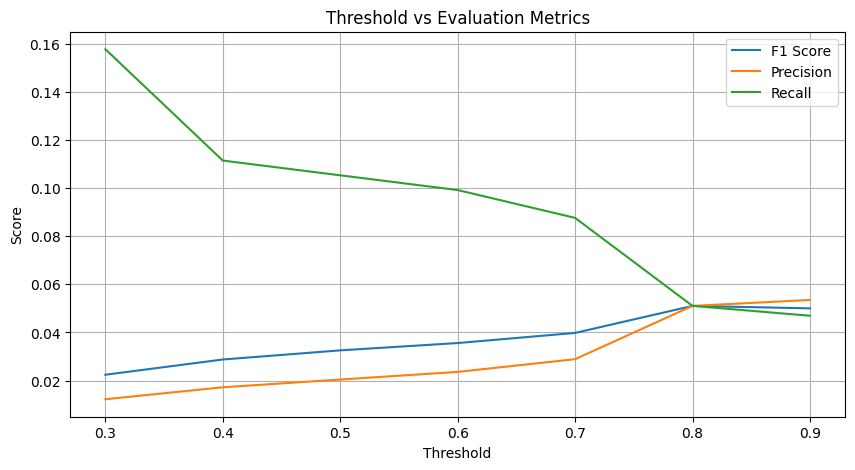

In [31]:
import matplotlib.pyplot as plt

thresholds = [r[0] for r in results]
f1s = [r[1] for r in results]
precisions = [r[2] for r in results]
recalls = [r[3] for r in results]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Evaluation Metrics")
plt.legend()
plt.grid(True)
plt.show()


| Metric        | What it means                                  | Prioritize when...                                                            |
| ------------- | ---------------------------------------------- | ----------------------------------------------------------------------------- |
| **Precision** | Of the predicted notes, how many were correct? | I care more about **avoiding false positives** (e.g., clean transcriptions) |
| **Recall**    | Of the actual notes, how many did we detect?   | I care more about **capturing all notes** (e.g., creative music generation) |
| **F1 Score**  | Harmonic mean of precision and recall          | I want a **balanced trade-off** between the two                             |


### Optimal Choice:
If F1 score peaks at a specific threshold (e.g., 0.5 or 0.6), that is often a good operating point.

If precision is very low but recall is high (as in my earlier result), it means my model predicts too many notes, many of which are incorrect.

### Best model setup (as per my latest tests):
Model type: LSTM with two layers (128 + 64 units), dropout = 0.3

Input normalization: Yes (StandardScaler applied to log-mel spectrograms)

Data shape: x_train: (N, 100, 128), y_train: (N, 100, 88)

Loss function: Binary Crossentropy

Threshold used for prediction: 0.5 — this gave non-zero predictions and worked with your evaluation metrics

## Let me try a deeper stacked, bidirectional LSTM architetcure
Stacked layers let the network learn higher‐level temporal patterns.

Bidirectional in the first layer gives the model both “past” and “future” context for each frame.

BatchNormalization + Dropout between layers helps with training stability and overfitting control.



In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dropout, TimeDistributed, Dense, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

# assume x_train_lstm_scaled has shape (N, T=100, F=128)
input_shape = (100, 128)

model_deep = Sequential([
    Input(shape=input_shape),

    # First bidirectional LSTM block
    Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat'),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM block
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM block
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Map each time step to 88 piano-key activations
    TimeDistributed(Dense(88, activation='sigmoid'))
])

model_deep.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_deep.summary()

# train with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_deep.fit(
    x_train_lstm_scaled,      # shape (N_train, 100, 128)
    y_train_lstm,             # shape (N_train, 100, 88)
    validation_data=(x_test_lstm_scaled, y_test_lstm),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop],
    verbose=2
)

# evaluate
loss, acc = model_deep.evaluate(x_test_lstm_scaled, y_test_lstm, verbose=0)
print(f"Deep LSTM Test Accuracy: {acc:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 100, 88)             │           5,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,208 (1.97 MB)

 Trainable params: 516,312 (1.97 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
5/5 - 13s - 3s/step - accuracy: 0.0122 - loss: 0.8157 - val_accuracy: 0.0000e+00 - val_loss: 0.6852
Epoch 2/30
5/5 - 1s - 157ms/step - accuracy: 0.0605 - loss: 0.5601 - val_accuracy: 0.0000e+00 - val_loss: 0.6785
Epoch 3/30
5/5 - 1s - 154ms/step - accuracy: 0.0785 - loss: 0.4339 - val_accuracy: 0.0000e+00 - val_loss: 0.6736
Epoch 4/30
5/5 - 1s - 154ms/step - accuracy: 0.0880 - loss: 0.3143 - val_accuracy: 0.0000e+00 - val_loss: 0.6705
Epoch 5/30
5/5 - 1s - 251ms/step - accuracy: 0.0897 - loss: 0.1894 - val_accuracy: 0.0030 - val_loss: 0.6667
Epoch 6/30
5/5 - 1s - 155ms/step - accuracy: 0.0925 - loss: 0.0752 - val_accuracy: 0.0060 - val_loss: 0.6623
Epoch 7/30
5/5 - 1s - 154ms/step - accuracy: 0.0912 - loss: 0.0044 - val_accuracy: 0.0070 - val_loss: 0.6573
Epoch 8/30
5/5 - 1s - 153ms/step - accuracy: 0.0910 - loss: -8.4824e-02 - val_accuracy: 0.0070 - val_loss: 0.6507
Epoch 9/30
5/5 - 1s - 155ms/step - accuracy: 0.0978 - loss: -1.8746e-01 - val_accuracy: 0.0210 - val_loss: 0.

In [33]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# 1) Get raw predictions from your LSTM model (shape: [N, 88, 100])
y_pred_raw = model_lstm.predict(x_test_lstm_scaled)

# 2) Threshold into binary piano-roll (0/1)
threshold = 0.5
y_pred_bin = (y_pred_raw > threshold).astype(int)      # shape (N, 88, 100)
y_true_bin = (y_test_lstm      > 0.5).astype(int)      # ensure true is 0/1, shape (N, 88, 100)

# 3) Flatten time and note dimensions so sklearn sees 2D arrays: (N, 88*100)
N = y_true_bin.shape[0]
y_pred_flat = y_pred_bin.reshape(N, -1)
y_true_flat = y_true_bin.reshape(N, -1)

# Sanity check
assert y_pred_flat.shape == y_true_flat.shape, "Mismatch in shape!"
assert set(np.unique(y_pred_flat)).issubset({0,1})
assert set(np.unique(y_true_flat)).issubset({0,1})

# 4) Compute metrics
f1        = f1_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)
recall    = recall_score(y_true_flat, y_pred_flat, average='samples', zero_division=0)

print(f"Sample-wise F1 Score : {f1:.4f}")
print(f"Sample-wise Precision: {precision:.4f}")
print(f"Sample-wise Recall   : {recall:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sample-wise F1 Score : 0.0325
Sample-wise Precision: 0.0204
Sample-wise Recall   : 0.1053


### F1 Score Analysis from the Deeper Bidirectional LSTM
F1 score is worse than simpler LSTM model.
It can be normal for a “bigger” network to sometimes do worse than a simpler one.
more layers => more parameters => harder to train well, especially on a small dataset.

## Lets pick the simpler LSTM architecture and do Hyperparameter Tuning

1) LSTM architecture
Number of recurrent layers: 1 vs 2 vs 3 LSTM layers

Hidden units per layer: e.g. 32, 64, 128, 256

Bidirectional vs unidirectional: do you get better temporal context if you wrap an LSTM in Bidirectional(...)?

Whether to stack (e.g. 128→64 vs 128→128)

2) Regularization
Dropout rate (after each LSTM): 0.1 - 0.5

Recurrent dropout (inside the LSTM): 0.0 - 0.3

3) Optimization
Learning rate: 1e-2, 1e-3, 1e-4

Optimizer: Adam, RMSprop, SGD

Batch size: 4, 8, 16, 32

4) Sequence/window length
Sequence length (window_frames): I am currently slicing into 100-frame chunks (2.3 s). What if I try 50 frames (1.1 s) or 200 frames (4.5 s)?
Window size (frames per slice): 50, 100, 200

Hop/overlap: non-overlapping vs 50 % overlap vs full sliding windows—more data but more redundancy.
Hop/stride between windows if I overlap

5) Threshold for binarization
Decision threshold: Instead of hard-coding 0.5, sweep threshold: 0.3, 0.5, 0.7

6) Loss
Loss weighting: if “note on” is rare, weight positives higher in my binary_crossentropy or use a custom weighted loss

### In summary, I can tune:
Hyper-Parameter	Typical Values

LSTM units	32, 64, 128, 256

Layers	1 – 3

Dropout	0.1 – 0.5

Recurrent dropout	0.0 – 0.3

Learning rate	1e-2, 1e-3, 1e-4

Optimizer	Adam, RMSprop, SGD

Batch size	4, 8, 16, 32

Window size	50, 100, 200 frames

Threshold	0.3, 0.5, 0.7 for binarization


In [35]:
import kerastuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense

def build_lstm_model(hp):
    model = Sequential()
    # First LSTM block
    model.add(LSTM(
        units=hp.Choice("units1", [64, 128, 256]),
        return_sequences=True,
        input_shape=(hp.Choice("window", [50, 100, 200]), 128),
        recurrent_dropout=hp.Float("recur_drop1", 0.0, 0.3, step=0.1)
    ))
    model.add(Dropout(hp.Float("drop1", 0.1, 0.5, step=0.1)))
    # Optional second block
    if hp.Boolean("second_layer"):
        model.add(LSTM(
            units=hp.Choice("units2", [32, 64, 128]),
            return_sequences=True,
            recurrent_dropout=hp.Float("recur_drop2", 0.0, 0.3, step=0.1)
        ))
        model.add(Dropout(hp.Float("drop2", 0.1, 0.5, step=0.1)))
    # Output
    model.add(TimeDistributed(Dense(88, activation="sigmoid")))
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam","rmsprop"]),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="audio2midi"
)

tuner.search(
    x_train_lstm_scaled,
    y_train_lstm,
    validation_data=(x_test_lstm_scaled, y_test_lstm),
    epochs=20,
    batch_size=8 # picked randomly
)


Trial 20 Complete [00h 00m 25s]
val_loss: 0.06006984785199165

Best val_loss So Far: 0.045750197023153305
Total elapsed time: 00h 07m 15s
